### Representing and minimizing rules

*(You'll need to: `conda install pyrsistent networkx` and then `pip install nxpd`. You'll also need graphviz.)*

Our rules are represented as positive monotone formulas in CNF. This is flexible enough for practical purposes, while still allowing us to define a normal form suitable for diffing, etc.

A _clause_ is a set of literals, and a _formula_ a set of clauses. We sort each first by size, then lexicographically.

In [1]:
class Clause(object):
    def __init__(self, *args):
        self.literals = set(args)
        
    def __str__(self):
        return ", ".join(map(str, sorted(self.literals)))
    
    def _repr_pretty_(self, p, cycle):
       p.text(str(self) if not cycle else '...')
    
    def __lt__(self, other):
        if len(self.literals) == len(other.literals):
            return sorted(self.literals) < sorted(other.literals)
        return len(self.literals) < len(other.literals)
        
class Formula(object):
    def __init__(self, *args):
        self.clauses = set(args)
        
    def __str__(self):
        return " ".join(map(lambda x: "({})".format(x), sorted(self.clauses)))
    
    def _repr_pretty_(self, p, cycle):
       p.text(str(self) if not cycle else '...')
    
def formula(*sets):
    return Formula(*map(lambda s: Clause(*s), sets))

In [2]:
formula({'a', 'b', 'c'}, {'ab', 'e'}, {'a', 'ab', 'c'})

(ab, e) (a, ab, c) (a, b, c)

For any formula, we define a normal form which exists, is unique, and is equivalent to the original formula under the usual interpretation of boolean logic.

Clauses are always normal, since all literals are positive. Formulas are normalized by removing any clause subsumed by any other. A clause $c$ is _subsumed_ by a clause $s$ if $s \subseteq c$. This is the obvious $O(mn)$ algorithm. Our clauses are almost always of size 1, so this is just fine.

In [3]:
def subsumes(c, d):
    return c.literals.issubset(d.literals)

def normalize(formula):
    minimized = set()
    for c in formula.clauses:
        minimized = {s for s in minimized if not subsumes(c, s)}
        if not any(subsumes(s, c) for s in minimized):
            minimized.add(c)
    return Formula(*minimized)

In [4]:
form = formula({'a', 'b'}, {'b'}, {'a'}, {'c', 'd'}, {'a', 'c', 'd'}, {'c', 'd'})
form

(a) (b) (a, b) (c, d) (c, d) (a, c, d)

In [5]:
normalize(form)

(a) (b) (c, d)

### Matching

The problem of matching rules to contexts amounts to testing formulas against truth-value assignments. But there are a few particularities which apply to our setting...

 - we want to evaluate rules under partial assignments as well as total assignemnts, identifying
   rules which are not yet satisfied, but remain satisfiable by future assignments.
 - we're always monotonically extending partial assignments and then re-evaluating, so it seems 
   like a good idea to re-use the current state as a starting point for future evaluations.
 - many assignments will co-exist at the same time, and each may subsequently be used as the
   starting point for future evaluations.
   
If we use an algorithm that just freshly evaluates all the rules against each assignment from scratch, there's not much more to do. If, however, we want to use an algorithm that performs work incrementally from the prior assignment, then we also want persistent data structures so that the old and new states can co-exist without copying.

Here are some ideas...

#### Brute force

 1. Index rules by properties set in that context
 2. Do nothing else until a property is requested
 3. Find all rules setting that property
 4. Evaluate each rule against the current assignment
 5. Apply specificity logic, etc.
 
This might be just fine, particularly if there are lots of different properties with only a few settings each. For situations where lots of properties are queried and set in the same context, there are some simple tricks that could speed things up. For instance, a given rule could be marked as satisfied (or not) by a given assignment so that future properties queried in the same context wouldn't need to reevaluate those rules. But in the case where are many, many settings of the same property in a large number of different rules, this seems unavoidably pretty bad.

There maybe other use cases for which this approach wouldn't work as well. For instance, enumerating properties set in a given context, or enumerating all the possible values of a given key that could be added to reveal additional settings. Those are more rare, though, and it would be ok if they were more expensive, as long as they're tractable.

#### DAG/Rete

 1. Use rules to build an immutable graph, with root nodes for each literal
 2. As the context is extended with additional facts, propagate those facts through the graph,
    activating child nodes as appropriate
 3. When a node containing property settings is activated, add those settings to the properties
    visible in the current context
 4. Apply specificity logic, either separately or in step 3 when adding settings
 
This is most similar to the current implementation, and most similar to what I've implemented so far for CCS2. Given the requirements above, the node activation state must be kept separately from the main graph, and in a persistent data structure. Likewise the visible settings.

Querying properties and enumerating properties are both trivial. The problem of enumerating key values remains tricky, but I've already implemented one variant and it's not too bad.

There are lots of variants of this involving different approaches to building the DAG. Since we're dealing with CNF terms, one possibility is to build a graph for disjunctions and one for conjunctions (or, equivalently, a single graph in two layers). The only thing remaining then is to optimize the structure of each of those graphs to amortize work done at each step.

#### Other matching approaches

There are other matching approaches to indexing and matching boolean formulas. Perhaps one of these would be better, but it would need to support partial matching (to find satisfiable but not yet satisfied rules), and may need to support an incremental implementation using immutable data structures, depending on its overall performance.

###  The DAG approach

So let's give this approach a try... The DAG will be rooted with a bunch of literals, which in actual practice consist of key/value-pattern matchable forms, but for now we'll just leave opaque.

Nodes consist of an operation (and/or), an activation tally count, their children and their property settings. The top-level DAG contains an otherwise unused node for the root-level settings.

In [6]:
from enum import Enum
class Op(Enum):
    AND = 'AND'
    OR = 'OR'

class Node(object):
    def __init__(self, op, tallyCount):
        self.op = op
        self.tallyCount = tallyCount
        self.children = []
        self.props = {}

import collections

class Dag(object):
    def __init__(self):
        self.children = collections.defaultdict(lambda: [])
        self.rootSettings = Node(Op.OR, 0)

To add a formula to the dag, first add each of its clauses, then add the whole formula. We use the greedy subset cover approximation algorithm for each phase. NB: Here we rely on the fact that clauses and formulas are both ordered from smallest to largest.

In [7]:
def build_clause_node(dag, clause):
    if len(clause.literals) == 1:
        return dag.children[next(iter(clause.literals))]
    node = Node(Op.OR, 1)
    for literal in clause.literals:
        dag.children[literal].append(node)
    return node.children

def add(dag, formula):
    # TODO need a special case for the empty formula
    node = Node(Op.AND, len(formula.clauses))
    for clause in formula.clauses:
        build_clause_node(dag, clause).append(node)

In [8]:
dag = Dag()
add(dag, normalize(form))

Let's take a look at the result:

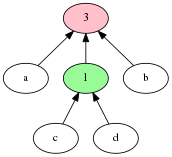

In [9]:
import networkx as nx
import nxpd

nxpd.nxpdParams['show'] = 'ipynb'

def draw(dag):
    G = nx.DiGraph()
    G.graph['dpi'] = 60
    G.graph['rankdir'] = 'BT'
    def add_nodes(p, ns):
        for n in ns:
            color = 'palegreen' if n.op == Op.OR else 'pink'
            G.add_node(n, label=n.tallyCount, style='filled', fillcolor=color)
            G.add_edge(p, n)
            add_nodes(n, n.children)
    for l, ns in dag.children.items():
        G.add_node(l)
        add_nodes(l, ns)
    
    return nxpd.draw(G)
    
draw(dag)    